"""
This notebook loads calcium traces from the Bartos lab (Hannah's data) and detects and clusters sequences.

Reference:
   [1] A persistent prefrontal reference frame across time and task rules. Nature Communications. https://doi.org/10.1038/s41467-024-46350-4

       DOI: https://www.nature.com/articles/s41467-024-46350-4


"""


In [1]:

import seaborn as sns
from cmath import nan
from traceback import format_exception_only
#from eagerpy import zeros_like
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.tree import plot_tree
#import mtools as mot
import mtools as mot


from scipy.stats import ranksums
from os.path import exists
from matplotlib.colors import ListedColormap
import seaborn as sns
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
import matplotlib.cm as cm
import random
import pickle
import scipy.io as spio
import pandas as pd
import matplotlib.animation as animation
from scipy.signal import find_peaks
import scipy.stats as stats
from rastermap import Rastermap
import scipy.signal
from helper_functions import separate_in,separate_in_2d_array,linearize_2d_track_single_run
import configparser
import os







plt.rcParams['svg.fonttype'] = 'none'  # Export text as SVG <text> objects, not paths
mpl.rcParams['xtick.major.size'] = 6    # Length of major ticks on x-axis
mpl.rcParams['xtick.major.width'] = 1.5 # Width of major ticks on x-axis
mpl.rcParams['xtick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['xtick.major.pad'] = 10    # Padding between ticks and x-axis labels

mpl.rcParams['ytick.major.size'] = 6    # Length of major ticks on y-axis
mpl.rcParams['ytick.major.width'] = 1.5 # Width of major ticks on y-axis
mpl.rcParams['ytick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['ytick.major.pad'] = 10    # Padding between ticks and y-axis labels


# Set default spine and tick settings globally for all plots
mpl.rcParams['axes.linewidth'] = 1.5     # Set the width of all spines (top, bottom, left, right)
mpl.rcParams['xtick.major.width'] = 1.5  # Width of major ticks on x-axis
mpl.rcParams['ytick.major.width'] = 1.5  # Width of major ticks on y-axis
mpl.rcParams['xtick.labelsize'] = 12     # Font size of x-axis tick labels
mpl.rcParams['ytick.labelsize'] = 12     # Font size of y-axis tick labels

# Define the helper function to hide spines
def hide_spines(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


from pathlib import Path
# Detect base directory
try:
    BASE_DIR = Path(__file__).resolve().parent  # For scripts
except NameError:
    BASE_DIR = Path.cwd()  # For Jupyter Notebooks

# Move one level up
BASE_DIR = BASE_DIR.parent

# Load config.ini
config = configparser.ConfigParser()
config.read(os.path.join(os.getcwd(), "config.ini"))

# Construct full paths using pathlib and ensure they end with a separator
skeletonsfolder = str((BASE_DIR / config["paths"]["skeletonsfolder"]).resolve()) + os.sep
savefolder = str((BASE_DIR / config["paths"]["savefolder"]).resolve()) + os.sep
datafolder = str((BASE_DIR / config["paths"]["datafolder"]).resolve()) + os.sep

# Print paths to verify
print("Base Directory:", BASE_DIR)
print("Skeletons Folder:", skeletonsfolder)
print("Save Folder:", savefolder)
print("Data Folder:", datafolder)



sleep__beforelearning = {'478':['session02','session03'],'480':['session02','session03'],'481':['session02','session03'],'483':['session02','session03'],'485':['session02','session03']}# before learning
sleep_leaned_before = {'478':['session02','session03'],'480':[],'481':['session02'],'483':['session02','session03'],'485':['session02']}# learned before task
sleep_leaned_after = {'478':['session05'],'480':[],'481':['session04'],'483':['session05','session06'],'485':['session04']}# learned after task


days= np.arange(0 ,32)# names to load data
daysstr = ["%02d" % (i,) for i in days]
months = np.arange(0,13)
monthsstr = ["%02d" % (i,) for i in months]
year=str(2022)
dates = []
for m in monthsstr:
    for d in daysstr:
        dates.append(year+m+d)




c:\Users\hamed\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


SystemError: initialization of _internal failed without raising an exception

## initializtion


In [2]:
folders = ['485']# Name of the animals' folder to analyse
place_cells=False# consider only place cells for analysis(list of the cells should be loaded)
cell_types='All'
nrm = np.load('nrm.npy',allow_pickle=True)
clusteringmethod = 'AHC'# what clustering algorithm will be used
Mode = 0 # this belongs to the old code and can be removed
signal_type = 'transients'
#signal_type = 'traces'
fs=20# sampling freq
thr_burts = .5# threshold for burst detection
winlen = 1000*fs# 10 sec cunnks for burst detection
tau=.001# deconv parameter
SpeedLimint=10# is not applied anymore
min_ratio = 1 # threshold to exclude bad templates

speed_thr=0# threshold to remove datapoint with low speed (Must be always  0, otherwise wrong results)
burst_length=0.5 # Duration of bursts (hardcoded in mtools (Tspare=.5))
burst_len=str(burst_length)+'s'


if clusteringmethod =='DB':# clustering algorithm
    clstr_param={'name':'DB', 'eps':3, 'min_samples': 10}
    cluster_decription = 'Name=' +clstr_param['name']+ ' eps=' +str(clstr_param['eps']) + ' minsample='+ str(clstr_param['min_samples'])+'  SpeedLimint='+ str(SpeedLimint)

elif clusteringmethod =='AHC':
    clstr_param={'name':'AHC', 'fac' : 1,'clnbr':10}
    cluster_decription='Name=' +clstr_param['name']+ ' fac=' +str(clstr_param['fac']) +'  SpeedLimint='+ str(SpeedLimint)



task = ['task_learning','task_learned']
print('Taks that are used to compute active cells: ', *task, sep=' and ')


descriotor='No_chunk_'+burst_len+'_'+signal_type#+'Randomized_seqs'

Taks that are used to compute active cells:  and task_learning and task_learned


## Get the index of cells that are acitve in all sessions

In [3]:
def process_sessions(task, dates, folders, datafolder, signal_type, use_uniqueindex=True):
    """
    Process session data to compute trial rates, identify cells active across all sessions,
    and plot the correct trial rate for each session.

    Parameters:
        task (list of str): List of task names.
        dates (list of str): List of session dates.
        folders (list of str): List of animal (folder) identifiers.
        datafolder (str): Base directory where data is stored.
        signal_type (str): String appended to filenames to indicate the signal type.
        use_uniqueindex (bool): If True, process and filter cells active in all sessions.

    Returns:
        dict: A dictionary containing:
            - 'trial_number': (currently unused) trial information.
            - 'correctrate': List of tuples (filename, correct trial rate, session type).
            - 'failedrate': (currently reset to an empty list at the end) failed trial rate info.
            - 'true_cell_idx': List of cell indices from metadata.
            - 'mask_commonids': Boolean array marking cells active across all sessions.
            - 'ncells': Number of cells active in every session.
            - 'session_mask': Dictionary mapping session names to an index.
            - 'newidx': List of common cell indices.
    """
    trial_number = {}
    correctrate = []
    failedrate = []
    true_cell_idx = []

    if use_uniqueindex:
        # Loop over each task, date, and folder to process the sessions
        for t, current_task in enumerate(task):
            print(current_task)
            for date in dates:
                for fol in folders:
                    # Choose filename based on the task type.
                    if current_task == 'sleep_learned_after':
                        # Be careful: if t==0 then task[t-1] may not exist.
                        if t == 0:
                            print("Warning: 'sleep_learned_after' encountered as the first task. Skipping...")
                            continue
                        filename = f"{date}_gcamp6f{fol}_{task[t-1]}.mat"
                        session_type = 'Learned'
                    else:
                        filename = f"{date}_gcamp6f{fol}_{current_task}.mat"
                        if current_task == 'task_learning':
                            session_type = 'Learning'
                        elif current_task == 'task_learned':
                            session_type = 'Learned'
                        else:
                            session_type = 'Unknown'

                    filepath = os.path.join(datafolder, fol, filename)
                    if os.path.exists(filepath):
                        # Generate an alternative filename (not used further in this snippet)
                        if current_task == 'sleep_learned_after':
                            base_filename = f"{date}_gcamp6f{fol}_{current_task}.mat"[:-4]
                            filenames = [f"{base_filename}_{signal_type}"]
                        else:
                            base_filename = filename[:-4]
                            filenames = [f"{base_filename}_{signal_type}"]

                        data = mot.loadmat(filepath)
                        print(os.path.join(fol, filename))

                        # For specific tasks, calculate trial rates.
                        if current_task in ['task_learning', 'task_learned']:
                            num_failed = len(data['EvtT']['failed_trials'])
                            num_correct = len(data['EvtT']['correct_trials'])
                            total_trials = num_failed + num_correct
                            # Avoid division by zero
                            if total_trials > 0:
                                failed_rate = num_failed / total_trials
                                correct_rate = num_correct / total_trials
                            else:
                                failed_rate = 0
                                correct_rate = 0

                            failedrate.append((filename, failed_rate))
                            # Append a tuple with the session type for later plotting.
                            correctrate.append((filename, correct_rate, session_type))

                        # Save cell index data from metadata.
                        true_cell_idx.append(data['metadata']['CellRegCellID'])

    # Plot the correct trial rate with updated appearance.
    # The x-axis now shows "Day 1", "Day 2", ... and bars are colored by session type.
    x = np.arange(len(correctrate))
    learning_x = []
    learned_x = []
    learning_values = []
    learned_values = []
    for i, (fname, rate, sess_type) in enumerate(correctrate):
        if sess_type == 'Learning':
            learning_x.append(i)
            learning_values.append(rate)
        elif sess_type == 'Learned':
            learned_x.append(i)
            learned_values.append(rate)

    plt.figure(figsize=[4,3])
    bar_width = 0.8
    # Updated colors:
    # For Learning sessions, use a slightly darker light gray ("silver").
    # For Learned sessions, continue using "slategray".
    if learning_x:
        plt.bar(learning_x, learning_values, bar_width, color='silver', edgecolor='black', label='Learning')
    if learned_x:
        plt.bar(learned_x, learned_values, bar_width, color='slategray', edgecolor='black', label='Learned')
    
    # Set x-axis ticks to "Day 1", "Day 2", etc.
    plt.xticks(x, [f"Day {i+1}" for i in x], rotation=90)
    plt.xlabel("Session")
    plt.ylabel("Correct Trial Rate")
    plt.title(f"{fol}")
    plt.hlines(0.7, -1, len(correctrate), colors='k', linestyles='dashed')
    plt.hlines(0.5, -1, len(correctrate), colors='r', linestyles='dashed')
    plt.xlim([-1, len(correctrate)])
    plt.legend()
    plt.tight_layout()
    plt.savefig(savefolder+'Correct_rate'+fol+'.svg')
    plt.show()

    # Create a dictionary to map each session name to an index.
    session_names = [item[0] for item in correctrate]
    session_mask = {name: idx for idx, name in enumerate(session_names)}

    # Identify cells that are active in all sessions.
    true_cell_idx_array = np.array(true_cell_idx).T
    common_cell_indices = [i for i in range(true_cell_idx_array.shape[0])
                           if -1 not in true_cell_idx_array[i, :]]
    
    mask_commonids = np.zeros(true_cell_idx_array.shape[0], dtype=bool)
    mask_commonids[common_cell_indices] = True
    ncells = len(common_cell_indices)

    # Reset failedrate (if this is intended in your workflow)
    failedrate = []

    print('Number of active cells during tasks:', ncells)

    return {
        'trial_number': trial_number,
        'correctrate': correctrate,
        'failedrate': failedrate,
        'true_cell_idx': true_cell_idx,
        'mask_commonids': mask_commonids,
        'ncells': ncells,
        'session_mask': session_mask,
        'newidx': common_cell_indices
    }


task_learning
485\20220215_gcamp6f485_task_learning.mat
485\20220217_gcamp6f485_task_learning.mat
485\20220218_gcamp6f485_task_learning.mat
task_learned
485\20220307_gcamp6f485_task_learned.mat
485\20220308_gcamp6f485_task_learned.mat
485\20220309_gcamp6f485_task_learned.mat
485\20220310_gcamp6f485_task_learned.mat
485\20220316_gcamp6f485_task_learned.mat


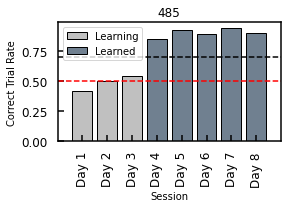

Number of active cells during tasks: 109


In [ ]:
## Load data of all sessions of one animal
results_all_sess = process_sessions(task, dates, folders, datafolder, signal_type)


# load skleton files and inedex of Place cells

In [ ]:
boz

NameError: name 'boz' is not defined

In [ ]:
skeletonsfolder

'C:\\Users\\hamed\\Desktop\\Hamed\\Github\\TP7\\data\\GCaMP6f_478-485\\skeleton\\'

In [ ]:

filepath_skel = os.path.join(skeletonsfolder, folders[0]+'_skeleton.npy')
skel = np.load(filepath_skel,allow_pickle=True)
#skel = np.load(skeletonsfolder+'\\'+folders[0]+'_skeleton.npy',allow_pickle=True) 
skel=skel.item()

# if place_cells:
#     dir_of_run='L'
#     saved_idx=np.load(savefolder+fol+'outward_'+dir_of_run+'_all_correct_all_days_original_bursts_200ms_transients_Allnew2200ms_burst_sig_fraction',allow_pickle=True)
#     sig_pc_L=saved_idx['sig_PC']

#     dir_of_run='R'
#     saved_idx=np.load(savefolder+fol+'outward_'+dir_of_run+'_all_correct_all_days_original_bursts_200ms_transients_Allnew2200ms_burst_sig_fraction',allow_pickle=True)
#     sig_pc_R=saved_idx['sig_PC']


#     significant_pc=sig_pc_L|sig_pc_R
#     cell_types='PC'
#     #cell_types='non_pc'

#     if cell_types=='Non_PC':
#         significant_pc=~significant_pc
# elif place_cells==False:
#         cell_types='All'
cell_types='All'

place_cell_name=cell_types


In [ ]:



# =============================================================================

significant_pc=[]
data_all_sessions, spks = mot.process_animal_data(task, dates, folders, datafolder, signal_type,
                                              burst_len, tau, place_cells, significant_pc,
                                              results_all_sess['newidx'], winlen, thr_burts, results_all_sess['session_mask'], skel)


Processing: 478/20220214_gcamp6f478_task_learning.mat (task_learning)
Burst length is  0.5


c:\Users\hamed\Desktop\Hamed\Github\TP7\public_code\mtools2.py:772: RuntimeWarning: invalid value encountered in true_divide
  cofseq = (itax @ vec[nv].transpose()) / nvec
c:\Users\hamed\anaconda3\lib\site-packages\numpy\core\shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
c:\Users\hamed\Desktop\Hamed\Github\TP7\public_code\mtools2.py:3099: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  session_mask[filename] * np.ones(len(np.asarray(seqs)[mask]))
c:\Users\hamed\Desktop\Hamed\Github\TP7\public_code\mtools2.py:311

Processing: 478/20220215_gcamp6f478_task_learning.mat (task_learning)
Burst length is  0.5
Processing: 478/20220216_gcamp6f478_task_learning.mat (task_learning)
Burst length is  0.5
Processing: 478/20220217_gcamp6f478_task_learning.mat (task_learning)
Burst length is  0.5
Processing: 478/20220318_gcamp6f478_task_learned.mat (task_learned)
Burst length is  0.5
Processing: 478/20220319_gcamp6f478_task_learned.mat (task_learned)
Burst length is  0.5
Processing: 478/20220320_gcamp6f478_task_learned.mat (task_learned)
Burst length is  0.5
Processing: 478/20220321_gcamp6f478_task_learned.mat (task_learned)
Burst length is  0.5
Processing: 478/20220327_gcamp6f478_task_learned.mat (task_learned)
Burst length is  0.5


## Load data of different sessions and merge them.

In [ ]:
# # show an example of sequence detection
# data = mot.loadmat('C:/Users/hamed/Desktop/Hamed/Github/TP7/data/GCaMP6f_478-485/485/20220310_gcamp6f485_task_learned.mat')

# # --- Preprocess the session signal ---

# # Retrieve metadata and compute sampling frequency.
# metadata = data['metadata']
# # Select cells active in all sessions using the provided index.
# true_cell_idx3 = np.array(metadata['CellRegCellID'])
# STMx2 = data['STMx'][signal_type][true_cell_idx3[newidx]]
# winlen=np.shape(STMx2)[1]-1
# poprate,id_peaks,bursts,seqs= mot.binned_burst(STMx2,winlen,thr_burts,fs,timewins=[])

# #xlim=[9330,11500]
# xlim=[12430,12550]

# speed_trl=[]
# fig, fig2, ax, ax0, ax1, ax2 = mot.plot_sequences_new(STMx2,seqs,bursts,id_peaks,thr_burts,fs,speed_trl,np.asarray(poprate),xlim)

# #ax0.set_xlim([10, 100])
# #ax.set_xlim([10, 100])

# ax0.set_xlim([220,400])
# ax.set_xlim([220,400])

# ax.set_ylim([0, 320])
# hide_spines(ax=ax)
# hide_spines(ax=ax0)
# hide_spines(ax=ax1)
# hide_spines(ax=ax2)

# # fig.savefig(savefolder+'sample Burst.svg',dpi=300)
# # fig2.savefig(savefolder+'sample Burst sorted.svg',dpi=300)

# # plt.show()

# # plt.xlim([10,111])
# # plt.xlim([10,141])

In [ ]:
combined_dicts = [data_all_sessions, results_all_sess['session_mask'] ]
with open(savefolder+folders[0]+'data_all_sessions'+cell_types+'_'+ descriotor+'newodrer','wb') as f:
    pickle.dump(combined_dicts, f)       


## Generate masks for differenct behaviral epochs

In [ ]:



# =============================================================================

Masks, sess_info, cond_info = mot.generate_masks(data_all_sessions, results_all_sess['session_mask'], results_all_sess['ncells'])
# =============================================================================


In [ ]:
Mask_and_sess = [Masks, results_all_sess['session_mask']]

with open(savefolder+folders[0]+'Mask_with_correct_cells','wb') as f:
    pickle.dump(Mask_and_sess, f) 

In [ ]:
Mask_and_sess

In [ ]:
boz

In [ ]:
# ## some visualizations. Can be commented just for visualiztion!
# # example of spike raster detected from the tranisent neural activity of all cells

# plt.imshow(sess_info['Spike_binary_cells'],vmin =0, vmax=.05, aspect='auto', cmap='gray_r',origin='lower',alpha=.9)

# ## visualize the transient rasters with rastermap

# model = Rastermap(n_components=1, n_X=90).fit(sess_info['extract'])# compute raster map based on the data of task x
# # compute correlation between speed and each cells activity

# isort = np.argsort(model.embedding[:,0])


# Sfilt=sess_info['extract'][isort, :]
# Sfilt = stats.zscore(Sfilt, axis=1)
# sorted_seqs=[]
# for seq in seqs:
#     sorted_seqs.append(np.ravel([np.where(isort==x)[0] for x in seq]))# sorting seqs according to rastermap



# plt.figure(figsize=(42,12))
# plt.subplot(211)

# plt.plot(np.asarray(sess_info['pop_rate'])/100,color='r')
# plt.eventplot(sess_info['id_peaks'])
# #plt.plot(sess_info['speed'],alpha=.2)
# plt.title(fol+'  Threshold=' +str(thr_burts),fontsize=34)
# plt.xlim([90010,100000])
# plt.ylim([0,3])

# plt.subplot(212)
# plt.imshow(Sfilt,vmin =0, vmax=3, aspect='auto', cmap='gray_r',origin='lower',alpha=.9)
# plt.xlim([90010,100000])

## Cluster all detected sequences

c:\Users\hamed\Desktop\Hamed\Github\TP7\public_code\mtools2.py:529: RuntimeWarning: invalid value encountered in true_divide
  cofseq = (itax @ vec.transpose()) / nvec


cluster [] is removed
Shape of bmat_temp_new: (44, 44)
Excluded clusters: [] Mixed clusters: [ 4.96818798 23.         24.        ]


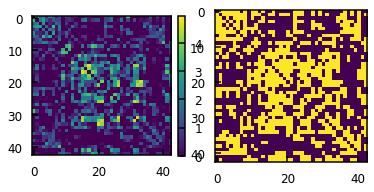

Shape of bmat_temp_new: (43, 43)
Excluded clusters: [] Mixed clusters: [ 4.69038056 15.         17.        ]


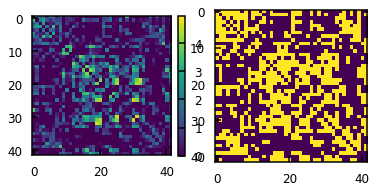

Shape of bmat_temp_new: (42, 42)
Excluded clusters: [] Mixed clusters: [ 4.65513125 19.         32.        ]


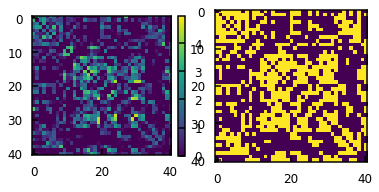

Shape of bmat_temp_new: (41, 41)
Excluded clusters: [] Mixed clusters: [ 4.55272067 24.         29.        ]


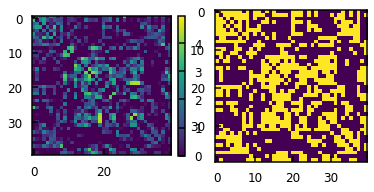

Shape of bmat_temp_new: (40, 40)
Excluded clusters: [] Mixed clusters: [ 4.40438064 19.         29.        ]


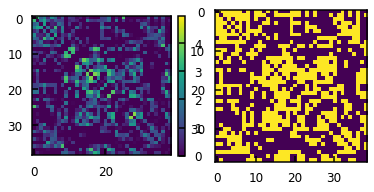

Shape of bmat_temp_new: (39, 39)
Excluded clusters: [] Mixed clusters: [ 4.08140518 27.         28.        ]


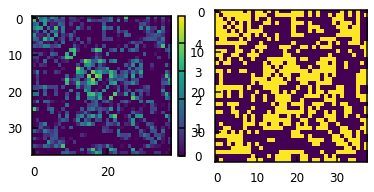

Shape of bmat_temp_new: (38, 38)
Excluded clusters: [] Mixed clusters: [ 4.00175652 16.         17.        ]


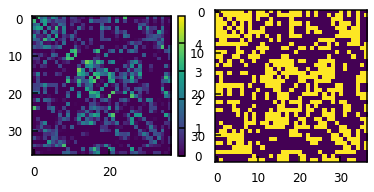

Shape of bmat_temp_new: (37, 37)
Excluded clusters: [] Mixed clusters: [ 3.9172992 12.        14.       ]


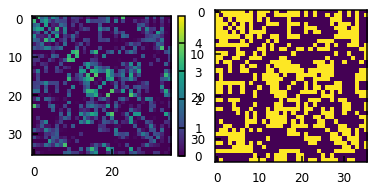

Shape of bmat_temp_new: (36, 36)
Excluded clusters: [] Mixed clusters: [ 3.63193318 15.         16.        ]


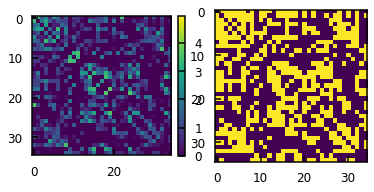

Shape of bmat_temp_new: (35, 35)
Excluded clusters: [] Mixed clusters: [ 3.63058973 18.         19.        ]


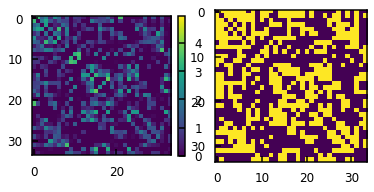

Shape of bmat_temp_new: (34, 34)
Excluded clusters: [] Mixed clusters: [ 3.77610297 15.         18.        ]


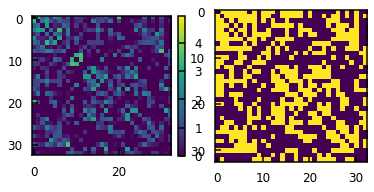

Shape of bmat_temp_new: (33, 33)
Excluded clusters: [] Mixed clusters: [ 3.58343309  0.         20.        ]


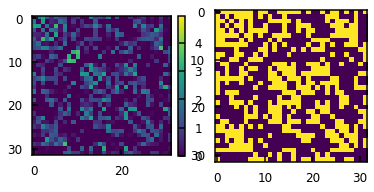

Shape of bmat_temp_new: (32, 32)
Excluded clusters: [] Mixed clusters: [ 3.54857952  8.         10.        ]


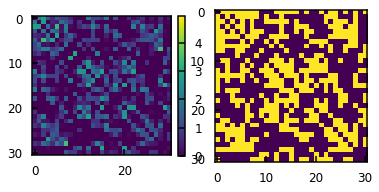

Shape of bmat_temp_new: (31, 31)
Excluded clusters: [] Mixed clusters: [ 3.49846291  7.         28.        ]


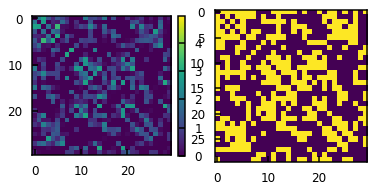

Shape of bmat_temp_new: (30, 30)
Excluded clusters: [] Mixed clusters: [3.36503476 2.         5.        ]


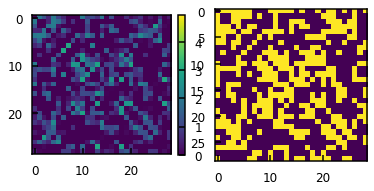

Shape of bmat_temp_new: (29, 29)
Excluded clusters: [] Mixed clusters: [ 2.98869283 13.         27.        ]


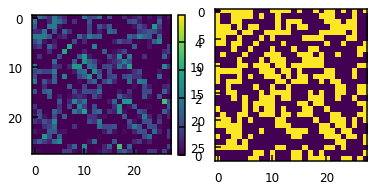

Shape of bmat_temp_new: (28, 28)
Excluded clusters: [] Mixed clusters: [ 3.50157958 17.         26.        ]


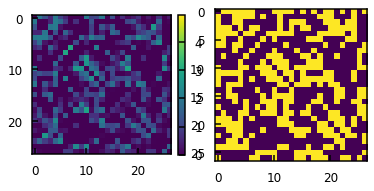

Shape of bmat_temp_new: (27, 27)
Excluded clusters: [] Mixed clusters: [2.98253607 6.         7.        ]


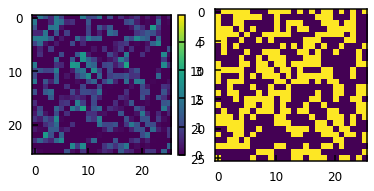

Shape of bmat_temp_new: (26, 26)
Excluded clusters: [] Mixed clusters: [ 2.89004302  9.         17.        ]


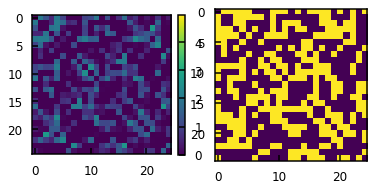

Shape of bmat_temp_new: (25, 25)
Excluded clusters: [] Mixed clusters: [ 2.70192652  2.         21.        ]


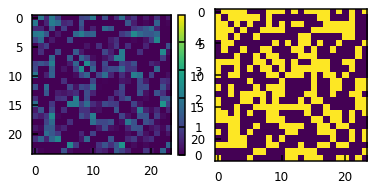

Shape of bmat_temp_new: (24, 24)
Excluded clusters: [] Mixed clusters: [ 2.58135421 15.         22.        ]


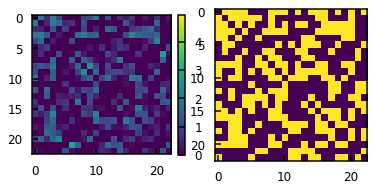

Shape of bmat_temp_new: (23, 23)
Excluded clusters: [] Mixed clusters: [ 2.907686  6.       21.      ]


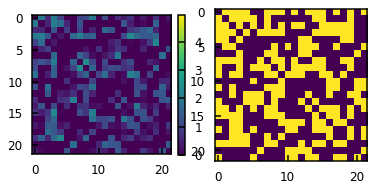

NameError: name 'fol' is not defined

In [ ]:
# clustering sequences

seqs=sess_info['seqs']# clustering will be done on all sequences (correct and failed trials). 
bursts=sess_info['bursts']
plot_figure=True

#*************** compute clusters from sequences ***************
repid,nsig,pval,bmat,zmat,corrmat = mot.allmot(seqs,nrm);
ids_clust = mot.cluster(bmat,zmat,clstr_param)
temp_info = mot.templates(bursts,seqs,nrm,ids_clust,min_ratio = min_ratio)
print('cluster', temp_info['exclude'] ,'is removed')
#temp_info_org=np.copy(temp_info['template'])
temp_info_test = copy.deepcopy(temp_info)
temp_info_new,mask = mot.merge_clusters2(temp_info,nrm,seqs,bursts,plot_figure,min_ratio=.1,z_thr=2.5)
#id_peaks=dats['sp_idpeak']
sess_info['ids_clust'] = temp_info_new['ids_clust'][0]
sess_info['template'] = temp_info_new['template']

if len(sess_info['template']) != len(np.unique(sess_info['ids_clust'])):# retrun error if cluster number and template length are not equal
    raise ValueError("Template lenght must be qual to cluter numbers")

sess_inf_plus_mask= {'sess_info': sess_info, 'Masks': Masks}
# with open(savefolder+folders[0]+'Sesseion_info'+'_'+place_cell_name+' '+cell_types+descriotor,'wb') as f:
#     pickle.dump(sess_inf_plus_mask, f) 


with open(savefolder+folders[0]+'Sesseion_info'+'test','wb') as f:
    pickle.dump(sess_inf_plus_mask, f)

In [ ]:
boz

In [ ]:
with open(savefolder+folders[0]+'Sesseion_info'+'test','wb') as f:
    pickle.dump(sess_inf_plus_mask, f)

In [ ]:
see_info_old=np.load(savefolder+folders[0]+'Sesseion_info'+'_'+place_cell_name+' '+cell_types+descriotor,allow_pickle=True)

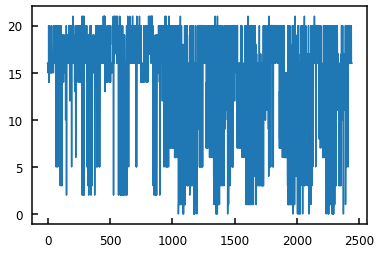

In [ ]:
plt.plot(see_info_old['sess_info']['ids_clust'])

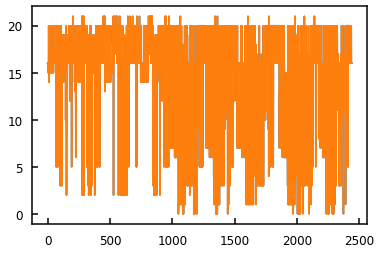

In [ ]:
plt.plot(sess_info['ids_clust'] )
plt.plot(see_info_old['sess_info']['ids_clust'])

In [ ]:
savefolder+folders[0]+'Sesseion_info'+'_'+place_cell_name+' '+cell_types+descriotor

'C:/Users/hamed/Desktop/Hamed/Github/TP7/results_new/478Sesseion_info_All AllNo_chunk_0.5s_transients'

In [ ]:
## run til here, the folloig cods are not used for the manuscript

In [ ]:
stop

NameError: name 'stop' is not defined

# Clustering shuffled sequences

In [ ]:
# shuffled_seqs=[]
# shuffled_bursts=[]
# for iseq, seq in enumerate(seqs):

#     indices = np.arange(len(seq))
#     np.random.shuffle(indices)
#     shuffled_seqs.append(seq[indices])
#     shuffled_bursts.append(replace_rows(bursts[iseq], seq, seq[indices]))

In [ ]:
#poprate,id_peaks,bursts,seqs,spike_times,rasters = mot.binned_burst(dats['sp_data'],winlen,thr_burts,fs,timewins)
# seqs=sess_info['seqs']# clustering will be done on all sequences (correct and failed trials). 
# bursts=sess_info['bursts']

plot_figure=True


# #id_peaks=sess_info['id_peaks']
# #*************** compute clusters from sequences
# repid,nsig,pval,bmat,zmat,corrmat = mot.allmot(shuffled_seqs,nrm);
# ids_clust = mot.cluster(bmat,zmat,clstr_param)
# temp_info = mot.templates(shuffled_bursts,shuffled_seqs,nrm,ids_clust,min_ratio = min_ratio)
# print('cluster', temp_info['exclude'] ,'is removed')
# #temp_info_org=np.copy(temp_info['template'])
# temp_info_test = copy.deepcopy(temp_info)
# temp_info_new,mask = mot.merge_clusters2(temp_info,nrm,shuffled_seqs,shuffled_bursts,plot_figure,min_ratio=.1,z_thr=2.5)
# #id_peaks=dats['sp_idpeak']
# sess_info['ids_clust'] = temp_info_new['ids_clust'][0]
# sess_info['seqs']=shuffled_seqs
# sess_info['bursts']=shuffled_bursts

# sess_inf_plus_mask= {'sess_info': sess_info, 'Masks': Masks}
# with open(savefolder+fol+'Sesseion_info'+'_'+place_cell_name+' '+cell_types+descriotor,'wb') as f:
#     pickle.dump(sess_inf_plus_mask, f) 

# Apply the masks and get the part of data you need. 

### Save data of outward runs for Place feild analysis

In [ ]:

# add the mask for speed. speed threshold is set to 5.
smooth_speed=mot.smooth_signal(sess_info['speed'], 13)# moving average over .5  second
Masks['speed_seq']=np.asarray(smooth_speed)[sess_info['id_peaks']]>speed_thr
Masks['speed']=smooth_speed>speed_thr


# select the data you need. Sessen number, epeoch, .... Selected data will be saved with corresposing name. Inward and outward data will be used by place filed code. 
sessin_numbers=np.arange(len(session_mask))#[4,5,6,7][0,1,2,3]##np.arange(len(session_mask))
#sessin_numbers=[6]
#sessin_numbers=[0,1,2,3,4,5,6,7] # soecify which session you want to work with
#celid=23# number of sample cell to show in the plot

#cond_number=[3] # conditon name (outwards)
#cond_number=[8,9,10,11] # inwards
#cond_number=[0,1] # sampling
#cond_number=[6,7] # reward
for cond_number in ([2,3]):
        
    trial_type=0 # 1 is correct       0 is failed

    if trial_type==1:
        type_name='correct'
    elif trial_type==0:
        type_name='failed'



    phase=None#None#,1 # 0 is learning,    1 is learned,  None is both
    if phase==None:
        phase_name='all'
    elif phase==0:
        phase_name='learning'
    elif phase==1:
        phase_name='learned'
            


    # odd_even=1# even trials
    # run_data_e=mot.apply_masks(sess_info,Masks,cond_number,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
    # #plt.title(run_data_e['sess_name']+' (even) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')

    # odd_even=0# odd trials
    # run_data_o=mot.apply_masks(sess_info,Masks,cond_number,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
    # #plt.title(run_data_e['sess_name']+' (odd) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')

    odd_even=None# all trials
    run_data_all=mot.apply_masks_test(sess_info,Masks,[cond_number],cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)



    reversed_mapping = {v: k for k, v in cond_names.items()}
    print(reversed_mapping.get(cond_number,'Key not found'),len(run_data_all['trace_cells']))
    animal_direction=reversed_mapping.get(cond_number,'Key not found')
    #animal_direction = mot.find_condition(cond_number,cond_names)
    #print(animal_direction)
    run_data_all['template']=sess_info['template']
    with open(savefolder+fol+animal_direction+'_'+ phase_name+'_'+type_name+'_'+descriotor+'_'+cell_types+'test_neworder_with_templates','wb') as f:
        pickle.dump(dict(run_data_all), f)   
    #plt.title(run_data_e['sess_name']+' (all) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')


outward_L 87
outward_R 87


c:\Users\hamed\Desktop\Hamed\Github\TP7\code\mtools.py:3449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  run_data['seqs']=np.asarray(sess_info['seqs'])[mask_sess_burst & mask_cond_burst & mask_odd_seqs & mask_correct_seqs & mask_phase_seqs & Masks['speed_seq']]


In [ ]:
## to get the merged data of sampling, outward and reward for burst replay analysis 
cell_types='All'
descriotor='No_chunk_0.5s_transients'
for fol in ['478','481','483','485']:

    #savefolder = 'C:/Users/hamed/Desktop/Hamed/Github/TP7/results/'
    #savefolder ='C:/Users/hamed/Desktop/Hamed/BCN/sequence/results/'
    #filename = '48520220215_gcamp6f485_task_learning.mat_all_sessions_all_days_transients'
    #filename = fol+'outward_'+dir_of_run+'_all_correct_all_days_original_bursts_neworder'+burst_len+'_transients_'+celltype
    #fol='481'
    #phase='all'
    filename = fol+'Sesseion_info_All AllNo_chunk_0.5s_transients'

    #filename = '478outward_R_all_correct_all_days_randomized_bursts_200ms_transients_allnew'

    data_all_tasks = np.load(join(savefolder, filename), allow_pickle=True)
    sess_info= data_all_tasks['sess_info']
    #Masks= data_all_tasks['Masks']# this mask does not include mask of correct trials of single cells


    filename_mask = fol+'Mask_with_correct_cells'
    Masks_ = np.load(join(savefolder, filename_mask), allow_pickle=True)# i added the correct masks for single cell data recently
    Masks=Masks_[0]


    #data_info=np.load(savefolder+fol+'data_all_sessions'+cell_types+'_'+ descriotor+'newodrer', allow_pickle=True)
    session_mask=Masks_[1]







 
    # add the mask for speed. speed threshold is set to 5.
    smooth_speed=mot.smooth_signal(sess_info['speed'], 13)# moving average over .5  second
    Masks['speed_seq']=np.asarray(smooth_speed)[sess_info['id_peaks']]>speed_thr
    Masks['speed']=smooth_speed>speed_thr


    # select the data you need. Sessen number, epeoch, .... Selected data will be saved with corresposing name. Inward and outward data will be used by place filed code. 
    sessin_numbers=np.arange(len(session_mask))#[4,5,6,7][0,1,2,3]##np.arange(len(session_mask))
    #sessin_numbers=[6]
    #sessin_numbers=[0,1,2,3,4,5,6,7] # soecify which session you want to work with
    #celid=23# number of sample cell to show in the plot

    #cond_number=[3] # conditon name (outwards)
    #cond_number=[8,9,10,11] # inwards
    #cond_number=[0,1] # sampling
    #cond_number=[6,7] # reward
    for con_number in ([1,3,5],[0,2,4],[0,2,4,1,3,5]):
            
        trial_type=1 # 1 is correct       0 is failed

        if trial_type==1:
            type_name='correct'
        elif trial_type==0:
            type_name='failed'



        phase=None#None#None#,1 # 0 is learning,    1 is learned,  None is both
        if phase==None:
            phase_name='all'
        elif phase==0:
            phase_name='learning'
        elif phase==1:
            phase_name='learned'
                


        # odd_even=1# even trials
        # run_data_e=mot.apply_masks(sess_info,Masks,cond_number,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
        # #plt.title(run_data_e['sess_name']+' (even) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')

        # odd_even=0# odd trials
        # run_data_o=mot.apply_masks(sess_info,Masks,cond_number,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
        # #plt.title(run_data_e['sess_name']+' (odd) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')

        odd_even=None# all trials
        run_data_all=mot.apply_masks_test(sess_info,Masks,con_number,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)



        name_of_conds=' '.join([xn for xn,x in cond_names.items() if x in con_number])

        run_data_all['template']=sess_info['template']
        # with open(savefolder+fol+animal_direction+'_'+ phase_name+'_'+type_name+'_'+descriotor+'_'+cell_types+'test_neworder_with_templates','wb') as f:
        #     pickle.dump(dict(run_data_all), f)   
        #plt.title(run_data_e['sess_name']+' (all) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')
        # with open(savefolder+fol+name_of_conds+'_'+ phase_name+'_'+type_name+'_'+descriotor+'_'+cell_types+'test_neworder_with_templates','wb') as f:
        #     pickle.dump(dict(run_data_all), f) 